<h1>SQLite Database Creator</h1>
<p>This notebook aggreates a range of data collected for the take-a-seat project and converts it into an SQLite database based on the following schema: <img src="schema.png" alt="Schema for Database"></p>
<p>The data is converted into csvs, then added into the SQLite .db</p>

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import sqlite3

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [2]:
DB = "hockey_data.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

<h2>Import and Clean up csvs</h2>
    <p><ul>
        <li><b>team_list</b>: This csv gets piped straight into its own table</li>
        <li><b>player_list</b>: Only count those players who have played more than 113 games (median no)</li>
</ul><p>

In [3]:
#import team list data
teams = pd.read_csv('team_list.csv',encoding = "ISO-8859-1")
teams['longitude'] = teams['longitude'].astype(float)
teams.drop(columns=['index'],inplace=True)
teams = teams.set_index('team_abbr')
teams.head()

,team_name,years_active,city,latitude,longitude,timezone
team_abbr,,,,,,
ANA,Anaheim Ducks,2006-2020,Anaheim,33.808,-117.876,-8
MDA,Mighty Ducks of Anaheim,1993-2006,Anaheim,33.808,-117.876,-8
ARI,Arizona Coyotes,2014-2020,Glendale,33.532,-112.261,-7
PHX,Phoenix Coyotes,1996-2014,Glendale,33.532,-112.261,-7
WIN,Winnipeg Jets,1990-1996,Winnipeg,49.893,-97.144,-6


In [4]:
#import player list data
players = pd.read_csv('nhlplayerlist_goalieswhwtg.txt','\t')
players.drop(columns=['Unnamed: 0','link','height','weight'],inplace=True)
players = players.set_index('unique_id')
#sort based ons whether or not there is injury data
players.head()

,player,year_start,year_finish,position,injuries_found,height_cm,weight_kg,total_games
unique_id,,,,,,,,
aebisda01,David Aebischer,2001,2008,G,0.0,185.0,83.0,214.0
aittosa01,Sami Aittokallio,2013,2014,G,1.0,185.0,78.0,2.0
allenja01,Jake Allen,2013,2020,G,4.0,188.0,92.0,289.0
alvesjo01,Jorge Alves,2017,2017,G,0.0,NaN,NaN,1.0
anderfr01,Frederik Andersen,2014,2020,G,27.0,193.0,104.0,369.0


Text(0.5, 1.0, '')

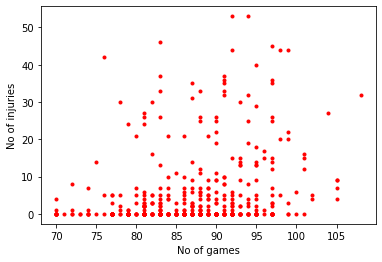

In [5]:
plt.plot(players['weight_kg'],players['injuries_found'],'r.')
plt.xlabel('No of games')
plt.ylabel('No of injuries')
plt.title('')

In [6]:
players['weight_kg'].mean()

86.6910229645094

In [7]:
(players['weight_kg']*players['injuries_found']).sum()/(players['injuries_found']).sum()

90.2672623883022

<h2>Wipe Database first</h2>
<p>Since we're building the db from scratch here</p>

In [8]:
tables = show_tables() #gets the tables in the db
with sqlite3.connect(DB) as conn:
    for row,data in tables.iterrows():
        run_command("DROP TABLE IF EXISTS {}".format(tables.loc[row,'name'])) #clear DB of existing tables

<h3>Enter Team Data</h3>

In [9]:
#make a new table with the appropriate keys
c1 = """
    CREATE TABLE IF NOT EXISTS team_list (
    team_abbr TEXT PRIMARY KEY,
    team_name TEXT,
    years_active TEXT,
    city TEXT,
    latitude REAL,
    longitude REAL,
    timezone INTEGER
);
"""
run_command(c1)

#inject data into the table
teams.to_sql('team_list',con=sqlite3.connect(DB), if_exists='append')

<h3>Enter Player Data</h3>

In [10]:
#make a new table with the appropriate keys
c1 = """
    CREATE TABLE IF NOT EXISTS player_list (
    unique_id TEXT PRIMARY KEY,
    player TEXT,
    year_start INTEGER,
    year_finish INTEGER,
    position TEXT,
    height_cm INTEGER,
    weight_kg INTEGER
);
"""

run_command(c1)

#inject data into the table
players[players['total_games']>=113][['player','year_start','year_finish','position','height_cm','weight_kg']].to_sql('player_list',con=sqlite3.connect(DB), if_exists='append')

In [11]:
run_command("DROP TABLE teams")
run_command("DROP TABLE team_list")

OperationalError: no such table: teams

In [81]:
show_tables()

,name,type
0,team_list,table
1,player_list,table


In [82]:
run_query("SELECT * FROM player_list")

,unique_id,player,year_start,year_finish,position,height_cm,weight_kg
0,aaltoan01,Antti Aalto,1998,2001,F,185,95
1,abdelju01,Justin Abdelkader,2008,2020,F,188,96
2,abergpo01,Pontus Aberg,2017,2020,F,180,88
3,acciano01,Noel Acciari,2016,2020,F,178,92
4,actonke01,Keith Acton,1980,1994,F,173,77
...,...,...,...,...,...,...,...
2334,zubovse01,Sergei Zubov,1993,2009,D,185,89
2335,zubruda01,Dainius Zubrus,1997,2016,F,196,102
2336,zuccama01,Mats Zuccarello,2011,2020,F,173,83
2337,zuckeja01,Jason Zucker,2012,2020,F,180,83
